# Libraries

In [1]:
!pip install underthesea

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.2 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Get data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from underthesea import word_tokenize, sent_tokenize, pos_tag
import regex
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#Feature Engineering
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
import gensim
from gensim.models.word2vec import Word2Vec
from gensim.models.doc2vec import TaggedDocument
import multiprocessing
from sklearn import utils
from gensim.models import KeyedVectors

#Over-sampling
from imblearn.over_sampling import SMOTE

#BI-LSTM
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, Bidirectional, LSTM, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


#Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report


# Get data

In [5]:
def get_data(data_path_sents, data_path_sentiments):
    with open(data_path_sents, 'r', encoding='utf-8') as file:
        sents = file.readlines()
    with open(data_path_sentiments, 'r', encoding='utf-8') as file:
        sentiments = file.readlines()
    return pd.DataFrame({'sentences':sents, 'sentiments':sentiments})

In [6]:
train_data = get_data('/content/drive/MyDrive/Colab Notebooks/VNmese_student_feedbacks_sentiment/train-20241208T060932Z-001/sents.txt', '/content/drive/MyDrive/Colab Notebooks/VNmese_student_feedbacks_sentiment/train-20241208T060932Z-001/sentiments.txt')
validation_data = get_data('/content/drive/MyDrive/Colab Notebooks/VNmese_student_feedbacks_sentiment/dev-20241208T060957Z-001/sents.txt', '/content/drive/MyDrive/Colab Notebooks/VNmese_student_feedbacks_sentiment/dev-20241208T060957Z-001/sentiments.txt')
test_data = get_data('/content/drive/MyDrive/Colab Notebooks/VNmese_student_feedbacks_sentiment/test-20241208T060919Z-001/sents.txt', '/content/drive/MyDrive/Colab Notebooks/VNmese_student_feedbacks_sentiment/test-20241208T060919Z-001/sentiments.txt')

In [7]:
print(train_data.shape)
print(validation_data.shape)
print(test_data.shape)

(11426, 2)
(1583, 2)
(3166, 2)


# Preprocessing

## Preprocessing sentiments

In [8]:
#Preprocessing sentiment
def process_sentiment(text):
    text = text.replace('\n', '')
    return text

In [9]:
train_data['sentiments'] = train_data['sentiments'].apply(lambda x: process_sentiment(str(x)))
train_data['sentiments'] = train_data['sentiments'].astype(int)
validation_data['sentiments'] = validation_data['sentiments'].apply(lambda x: process_sentiment(str(x)))
validation_data['sentiments'] = validation_data['sentiments'].astype(int)
test_data['sentiments'] = test_data['sentiments'].apply(lambda x: process_sentiment(str(x)))
test_data['sentiments'] = test_data['sentiments'].astype(int)

## Preprocessing sentences

In [10]:
#Load Teencode
file = open('/content/drive/MyDrive/Colab Notebooks/VNmese_student_feedbacks_sentiment/file_preprocess/teencode.txt', 'r', encoding="utf8")
teen_lst = file.read().split('\n')
teen_dict = {}
for line in teen_lst:
    key, value = line.split('\t')
    teen_dict[key] = str(value)
file.close()

#Load Stopwords
file = open('/content/drive/MyDrive/Colab Notebooks/VNmese_student_feedbacks_sentiment/file_preprocess/vietnamese-stopwords-dash.txt', 'r', encoding="utf8")
stopwords_lst = file.read().split('\n')
file.close()

In [11]:
def process_text(text, dict_teen):
    document = text.lower() #change to lowercase
    document = document.replace("’",'') #get rid of '
    document = regex.sub(r'\.+', ".", document) #replace ... to .
    new_sentence =''
    for sentence in sent_tokenize(document):
        ###### CONVERT TEENCODE
        sentence = ' '.join(dict_teen[word] if word in dict_teen else word for word in sentence.split())

        ###### DEL Punctuation & Numbers
        pattern = r'(?i)\b[a-záàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệóòỏõọôốồổỗộơớờởỡợíìỉĩịúùủũụưứừửữựýỳỷỹỵđ]+\b'
        sentence = ' '.join(regex.findall(pattern,sentence))

        new_sentence = new_sentence + sentence
    document = new_sentence

     ###### DEL excess blank space
    document = regex.sub(r'\s+', ' ', document).strip()
    return document

In [12]:
train_data['sentences'] = train_data['sentences'].apply(lambda x: process_text(str(x), teen_dict)) #pass each line to process_text
validation_data['sentences'] = validation_data['sentences'].apply(lambda x: process_text(str(x), teen_dict))
test_data['sentences'] = test_data['sentences'].apply(lambda x: process_text(str(x), teen_dict))

## Blank spaces

In [13]:
def drop_empty_rows(df, column_name):
    df_cleaned = df[df[column_name] != ""]
    return df_cleaned

In [14]:
train_data = drop_empty_rows(train_data, 'sentences')
validation_data = drop_empty_rows(validation_data, 'sentences')
test_data = drop_empty_rows(test_data, 'sentences')

# Split dataset

In [15]:
x_train = train_data['sentences']
x_validation = validation_data['sentences']
x_test = test_data['sentences']

y_train = train_data['sentiments']
y_validation = validation_data['sentiments']
y_test = test_data['sentiments']

# Feature Engineering

In [16]:
model_ug_cbow = KeyedVectors.load('/content/drive/MyDrive/Colab Notebooks/VNmese_student_feedbacks_sentiment/model_save/w2v_model_ug_cbow.word2vec')
model_ug_sg = KeyedVectors.load('/content/drive/MyDrive/Colab Notebooks/VNmese_student_feedbacks_sentiment/model_save/w2v_model_ug_sg.word2vec')

In [17]:
#combine cbow and skipgram
embeddings_index = {}
for w in model_ug_cbow.wv.key_to_index.keys():
    embeddings_index[w] = np.append(model_ug_cbow.wv[w],model_ug_sg.wv[w])
print('Found %s word vectors.' % len(embeddings_index))

Found 1644 word vectors.


In [ ]:
print(embeddings_index)

## Create vocabulary and feature engineering x_train, x_val, x_test

In [18]:
#num_words: thể hiện số lượng từ tối đa mà tokenizer giữ lại
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(x_train)#chuyển đổi văn bản thành các số nguyên

In [19]:
len(tokenizer.word_index)

2159

In [ ]:
tokenizer.word_index

{'<OOV>': 1,
 'viên': 2,
 'giảng': 3,
 'dạy': 4,
 'thầy': 5,
 'sinh': 6,
 'học': 7,
 'bài': 8,
 'tình': 9,
 'không': 10,
 'và': 11,
 'có': 12,
 'rất': 13,
 'nhiệt': 14,
 'cho': 15,
 'hiểu': 16,
 'nhiều': 17,
 'tập': 18,
 'dễ': 19,
 'thực': 20,
 'cô': 21,
 'môn': 22,
 'nên': 23,
 'tâm': 24,
 'với': 25,
 'thức': 26,
 'được': 27,
 'kiến': 28,
 'hơn': 29,
 'tận': 30,
 'em': 31,
 'của': 32,
 'hay': 33,
 'lớp': 34,
 'hành': 35,
 'các': 36,
 'cần': 37,
 'để': 38,
 'trong': 39,
 'làm': 40,
 'quá': 41,
 'tốt': 42,
 'khó': 43,
 'vui': 44,
 'là': 45,
 'giáo': 46,
 'về': 47,
 'chưa': 48,
 'lý': 49,
 'cách': 50,
 'truyền': 51,
 'trình': 52,
 'một': 53,
 'những': 54,
 'đạt': 55,
 'giờ': 56,
 'khi': 57,
 'tính': 58,
 'thể': 59,
 'đề': 60,
 'thời': 61,
 'dẫn': 62,
 'thuyết': 63,
 'giải': 64,
 'lên': 65,
 'nói': 66,
 'chỉ': 67,
 'việc': 68,
 'đến': 69,
 'dụng': 70,
 'nhưng': 71,
 'như': 72,
 'gian': 73,
 'hướng': 74,
 'hơi': 75,
 'giúp': 76,
 'dung': 77,
 'kỹ': 78,
 'thì': 79,
 'còn': 80,
 'tiết': 81,


In [20]:
length = []
for x in [x_train, x_validation, x_test]:
    for i in x:
        length.append(len(i.split()))
print(max(length))

150


In [21]:
senquences_digit = tokenizer.texts_to_sequences(x_train)
#Chuẩn hóa độ dài senquences_digit
x_train_seq = pad_sequences(senquences_digit, maxlen=max(length), truncating='post', padding='post')
#truncating=post: Nếu một chuỗi vượt quá độ dài maxlen, phần dư thừa sẽ bị cắt bớt ở cuối chuỗi.
#padding=post:Nếu một chuỗi ngắn hơn maxlen, các giá trị 0 sẽ được thêm vào cuối chuỗi để đạt đến độ dài maxlen.
print(x_train_seq.shape)

(11426, 150)


In [22]:
x_train_seq[100,:]

array([447, 147, 154,   3,   2,   4,  13,  42,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0], dtype=int32)

In [23]:
senquences_val = tokenizer.texts_to_sequences(x_validation)
x_val_seq = pad_sequences(senquences_val, maxlen=max(length), truncating='post', padding='post')
senquences_test = tokenizer.texts_to_sequences(x_test)
x_test_seq = pad_sequences(senquences_test, maxlen=max(length), truncating='post', padding='post')
print(x_val_seq.shape)
print(x_test_seq.shape)

(1583, 150)
(3166, 150)


## Handling imbanlanced label

In [24]:
smote = SMOTE(random_state=42)
x_train_seq, y_train = smote.fit_resample(x_train_seq, y_train)

In [25]:
y_train.value_counts()

,count
sentiments,
2,5643
0,5643
1,5643


## Create embedding matrix

In [26]:
#Khởi tạo ma trận nhúng với hàng là 10000 và 200 cột
num_words = 10000
embedding_matrix = np.zeros((num_words, 200))
#Điền giá trị vào ma trận nhúng
for word, i in tokenizer.word_index.items():#lấy key và value trong thư viện
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# BI-LSTM

In [27]:
input_dim = 10000          # Số từ trong từ điển
output_dim = 200           # Số chiều của vector nhúng
dropout_threshold = 0.2    # Ngưỡng dropout
learning_rate = 0.001      # Tốc độ học
#input_length Độ dài tối đa của chuỗi đầu vào
# Xây dựng mô hình
bilstm_model = Sequential()
# Thêm lớp Embedding
bilstm_model.add(Embedding(input_dim=input_dim, output_dim=output_dim, weights=[embedding_matrix], input_length=max(length), trainable=True))
# Thêm Bidirectional LSTM
bilstm_model.add(Bidirectional(LSTM(units=output_dim, dropout=dropout_threshold, return_sequences=True), merge_mode='concat'))
bilstm_model.add(Bidirectional(LSTM(units=output_dim, return_sequences=True)))
# GlobalAveragePooling để giảm chiều dữ liệu
bilstm_model.add(GlobalAveragePooling1D())
# Thêm các lớp Dense và Dropout
bilstm_model.add(Dense(500, activation='relu'))
bilstm_model.add(Dropout(0.2))
bilstm_model.add(Dense(200, activation='relu'))
bilstm_model.add(Dropout(0.2))
bilstm_model.add(Dense(100, activation='relu'))
bilstm_model.add(Dropout(0.1))
bilstm_model.add(Dense(50, activation='relu'))
# Lớp đầu ra cho 3 nhãn
bilstm_model.add(Dense(3, activation='softmax'))  # 3 nhãn, dùng softmax cho phân loại đa lớp
# Biên dịch mô hình
adam = Adam(learning_rate=learning_rate)
bilstm_model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [28]:
# Callback: Lưu mô hình tốt nhất
callback_model = ModelCheckpoint(
    filepath='/content/drive/MyDrive/Colab Notebooks/VNmese_student_feedbacks_sentiment/model_save/bilstm_model_best.keras',  # Tên file lưu mô hình tốt nhất
    monitor='val_loss',              # Theo dõi hàm mất mát trên tập validation
    save_best_only=True,             # Chỉ lưu mô hình tốt nhất
    save_weights_only=False,         # Lưu toàn bộ mô hình
    verbose=1                        # Hiển thị thông tin khi lưu
)
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=5, # Số epoch chờ trước khi dừng
    restore_best_weights=True, # Khôi phục trọng số tốt nhất
    verbose=1
)
# Huấn luyện mô hình
history = bilstm_model.fit(
    x_train_seq, y_train,
    validation_data=(x_val_seq, y_validation),
    epochs=20,                 # Số epoch
    batch_size=32,             # Kích thước batch
    callbacks=[callback_model, early_stopping_callback] # Sử dụng callback
)

Epoch 1/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6545 - loss: 0.7635
Epoch 1: val_loss improved from inf to 0.37737, saving model to /content/drive/MyDrive/Colab Notebooks/VNmese_student_feedbacks_sentiment/model_save/bilstm_model_best.keras
530/530 ━━━━━━━━━━━━━━━━━━━━ 35s 46ms/step - accuracy: 0.6546 - loss: 0.7633 - val_accuracy: 0.8718 - val_loss: 0.3774
Epoch 2/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8549 - loss: 0.4080
Epoch 2: val_loss improved from 0.37737 to 0.28312, saving model to /content/drive/MyDrive/Colab Notebooks/VNmese_student_feedbacks_sentiment/model_save/bilstm_model_best.keras
530/530 ━━━━━━━━━━━━━━━━━━━━ 24s 46ms/step - accuracy: 0.8550 - loss: 0.4080 - val_accuracy: 0.9078 - val_loss: 0.2831
Epoch 3/20
530/530 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9143 - loss: 0.2659
Epoch 3: val_loss did not improve from 0.28312
530/530 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.9143 - loss: 0.2659 - val_accuracy: 0.9015 - va

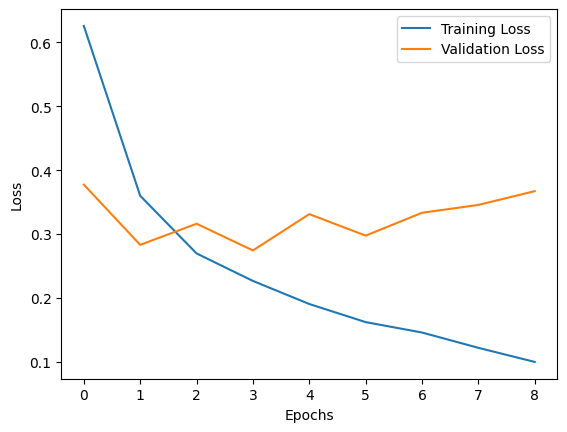

In [29]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [30]:
train_loss, train_accuracy = bilstm_model.evaluate(x_train_seq, y_train, verbose=0)
val_loss, val_accuracy = bilstm_model.evaluate(x_val_seq, y_validation, verbose=0)

print(f"Train Set Error: {train_loss* 100:.2f}%")
print(f"Validation Set Error: {val_loss* 100:.2f}%")

Train Set Error: 17.18%
Validation Set Error: 28.16%


In [31]:
y_pred_proba = bilstm_model.predict(x_test_seq)
y_pred = np.argmax(y_pred_proba, axis=1)
y_pred

99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step


array([2, 2, 2, ..., 2, 1, 0])

In [32]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy_train: {accuracy_score(y_train, np.argmax(bilstm_model.predict(x_train_seq), axis=1))}')
print(f'Accuracy_test: {accuracy:.4f}')
precision = precision_score(y_test, y_pred, average='weighted')
print(f'Precision: {precision:.4f}')
recall = recall_score(y_test, y_pred, average='weighted')
print(f'Recall: {recall:.4f}')
f1 = f1_score(y_test, y_pred, average='weighted')
print(f'F1-score: {f1:.4f}')
# In ra báo cáo phân loại
print("Classification Report:")
print(classification_report(y_test, y_pred))

530/530 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step
Accuracy_train: 0.9443558390926812
Accuracy_test: 0.8917
Precision: 0.8981
Recall: 0.8917
F1-score: 0.8946
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      1409
           1       0.36      0.43      0.39       167
           2       0.94      0.92      0.93      1590

    accuracy                           0.89      3166
   macro avg       0.74      0.76      0.75      3166
weighted avg       0.90      0.89      0.89      3166



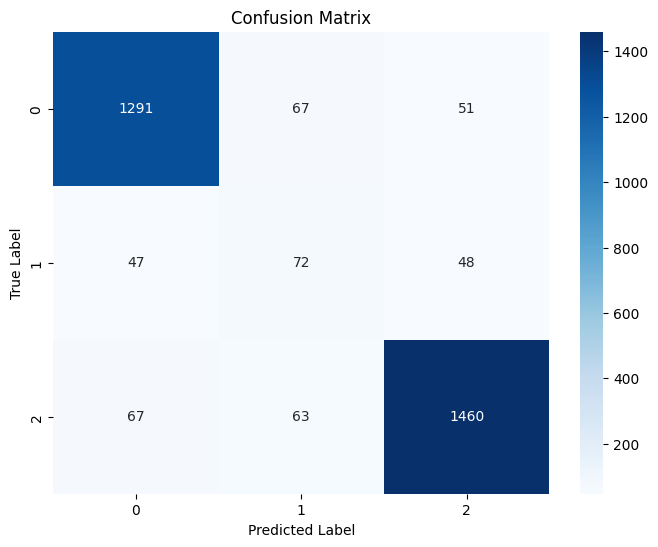

      0   1     2
0  1291  67    51
1    47  72    48
2    67  63  1460


In [33]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
print(pd.DataFrame(cm))